In [2]:
!pip install geopandas

     |████████████████████████████████| 994 kB 14.7 MB/s 
     |████████████████████████████████| 6.6 MB 23.0 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline

# **Reading Inputs**

Here, we input Bangalore Travel time data for January 2020 to March 2020. We consider the weekly aggregate for modeling. 

In [4]:
travel_times = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/Travel_Times.csv')
bnglr_wards_hourly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore-wards-2020-1-All-HourlyAggregate.csv')
# bnglr_wards_weekly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore-wards-2020-1-WeeklyAggregate.csv')
# bnglr_wards_monthly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore-wards-2020-1-All-MonthlyAggregate.csv')

We would like to use hourly travel time average for modeling. Let's use this first, then you can play around with other time-series data!

In [ ]:
bnglr_wards_hourly.head(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,183,54,22,3071.62,553.06,3016.74,1.22
1,186,24,22,991.61,241.55,969.45,1.22
2,181,74,22,2327.47,361.36,2300.49,1.16
3,187,14,22,1609.11,453.05,1551.08,1.31
4,182,64,22,2635.08,565.12,2580.12,1.22


Text(0, 0.5, 'Mean travel time in mins')

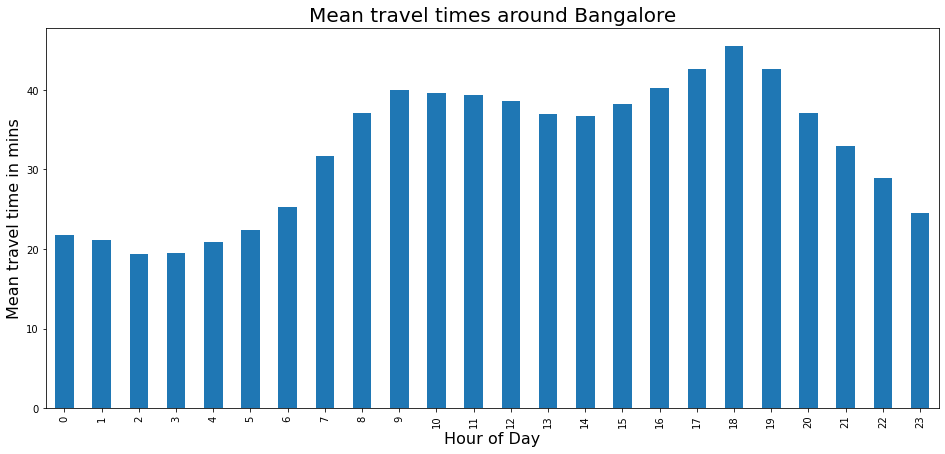

In [5]:
mean_travel_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,7))
plt.set_title('Mean travel times around Bangalore', fontsize=20)
plt.set_xlabel('Hour of Day', fontsize = 16)
plt.set_ylabel('Mean travel time in mins', fontsize = 16)

Text(0, 0.5, 'Std Dev off travel time in mins')

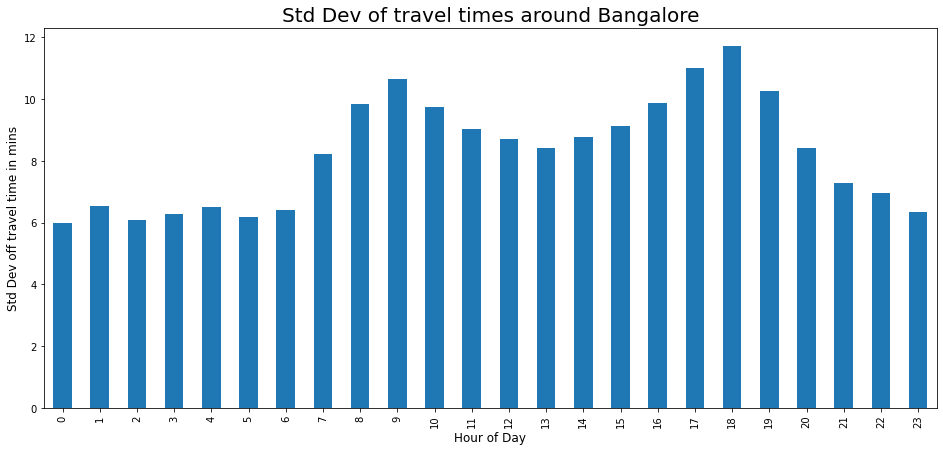

In [6]:
std_dev_travel_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_travel_time_by_hour_of_day.plot(kind="bar", figsize = (16,7))
plt.set_title('Std Dev of travel times around Bangalore', fontsize =20)
plt.set_xlabel('Hour of Day', fontsize = 12)
plt.set_ylabel('Std Dev off travel time in mins', fontsize = 12)

# **The Json Data (Map)**

In [7]:
bglr = gpd.read_file('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore_wards.json')

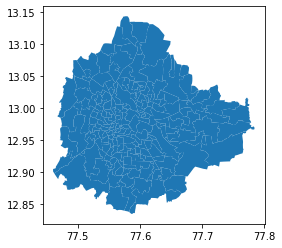

In [8]:
bglr.plot()

In [9]:
bglr.head()

,WARD_NO,WARD_NAME,MOVEMENT_ID,DISPLAY_NAME,geometry
0,2,Chowdeswari Ward,1,"Unnamed Road, Bengaluru","MULTIPOLYGON (((77.59229 13.09720, 77.59094 13..."
1,3,Atturu,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...","MULTIPOLYGON (((77.56862 13.12705, 77.57064 13..."
2,4,Yelahanka Satellite Town,3,"15th A Cross Road, Yelahanka Satellite Town, Y...","MULTIPOLYGON (((77.59094 13.09842, 77.59229 13..."
3,51,Vijnanapura,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...","MULTIPOLYGON (((77.67683 13.01147, 77.67695 13..."
4,53,Basavanapura,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...","MULTIPOLYGON (((77.72899 13.02061, 77.72994 13..."


# **Picking centroids to represent an area**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


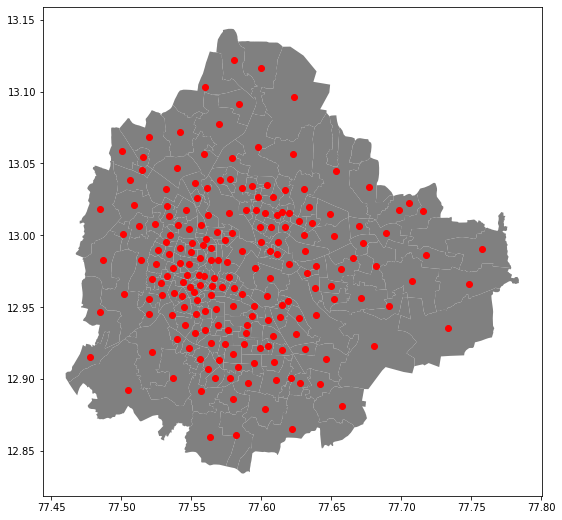

In [10]:
bglr = bglr.drop(columns=['WARD_NO', 'MOVEMENT_ID'])
bglr_c = bglr.copy()
bglr_c.geometry = bglr_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
bglr_c.plot(color='red',ax=ax)

In [11]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"Unnamed Road, Bengaluru"
1,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya..."
2,3,"15th A Cross Road, Yelahanka Satellite Town, Y..."
3,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay..."
4,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish..."


# Get some random points from each ward to diversify representation

In [12]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:3]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(bglr)
diversified_points.sample(5)

,WARD_NAME,DISPLAY_NAME,geometry
155,Radhakrishna Temple Ward,"400 8th Cross Road, RMV 2nd Stage, Dollars Col...",POINT (77.57150 13.04090)
414,Hombegowda Nagara,"0 16th Cross Road, Lakkasandra Extension, Wils...",POINT (77.60173 12.94337)
587,Horamavu,"0 Horamavu Agara Main Road, 1st Block, Mallapp...",POINT (77.64338 13.04550)
461,Lakkasandra,"0 9th Cross Road, Rangadasapp Layout, Pukhraj ...",POINT (77.60583 12.94295)
359,Vijayanagar,"1100 2nd Main Road, Hoshalli Extension, Stage ...",POINT (77.55239 12.97161)


In [13]:
diversified_points.shape

(594, 3)

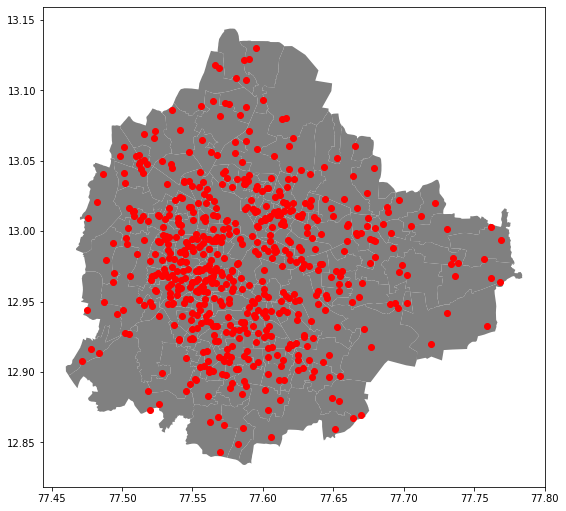

In [14]:
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# Cleaning up data for analysis
Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [15]:
time_df = pd.merge(bnglr_wards_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
272319,198,197,20,4001.08,583.40,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272337,198,197,21,3636.68,614.63,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272324,198,197,22,3082.11,471.47,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272330,198,197,23,2905.84,619.53,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
366043,198,198,23,458.84,562.24,"BGS Road, Kodipalya, Bengaluru","BGS Road, Kodipalya, Bengaluru"


In [16]:
bglr_c.shape

(198, 3)

In [17]:
diversified_points.shape

(594, 3)

In [18]:
full_bglr = bglr_c.append(diversified_points, ignore_index=True)
full_bglr.shape

(792, 3)

In [19]:
full_bglr.head()

,WARD_NAME,DISPLAY_NAME,geometry
0,Chowdeswari Ward,"Unnamed Road, Bengaluru",POINT (77.58042 13.12171)
1,Atturu,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...",POINT (77.56004 13.10280)
2,Yelahanka Satellite Town,"15th A Cross Road, Yelahanka Satellite Town, Y...",POINT (77.58393 13.09099)
3,Vijnanapura,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...",POINT (77.66957 13.00606)
4,Basavanapura,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...",POINT (77.71546 13.01685)


In [20]:
time_df2 = pd.merge(time_df, full_bglr, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_bglr, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Ward Name,Source Geometry,Destination Ward Name,Destination Geometry
9335731,120,149,10,2096.80,678.12,"1100 2nd Main Road, Hoshalli Extension, Stage ...","300 6th Cross Road, 1st Block, 7th Block, Jaya...",Vijayanagar,POINT (77.54704 12.97209),Karisandra,POINT (77.57391 12.92872)
4427038,108,74,17,1795.64,385.30,"G/10, Mariappanapalya, Rajaji Nagar, Bengaluru","Saijothi, 1st Cross Road, D Costa Layout, Cook...",Prakash Nagar,POINT (77.55714 12.99642),Maruthi Seva Nagar,POINT (77.63104 12.99871)
2959125,103,48,21,1335.46,671.33,"22/A, West Of Chord Road, 3rd Stage, Basaveshw...","0 DB Street, M V Block, Guttahalli, Bengaluru",Basaveshwara Nagar,POINT (77.54413 12.98653),Rajamahal Guttahalli,POINT (77.58098 13.00020)


In [21]:
time_df2.shape

(13227072, 11)

In [32]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

output_path = '/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Output/'

In [33]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2

In [34]:
filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, filename)
except:
    pass
  

# Modeling
Model without eval set 

In [35]:
X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [56]:
# takes time : 30 mins (100 n_estimators)
import xgboost as xgb

filename = 'XGB_model_5.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4, objective='reg:squarederror')
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

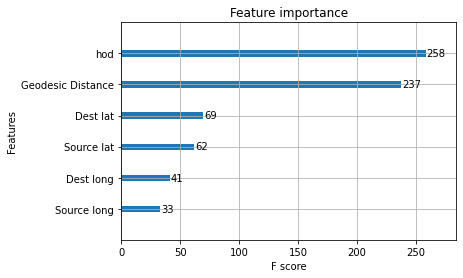

In [57]:
xgb.plot_importance(my_model)

In [58]:
#@title Default title text
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.8649942414749451

MSE: 159157.1102226522

RMSE: 398.9449964878018

MAE: 295.80051557540463



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


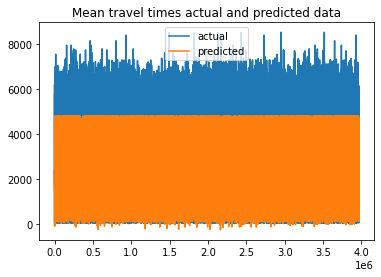

In [59]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

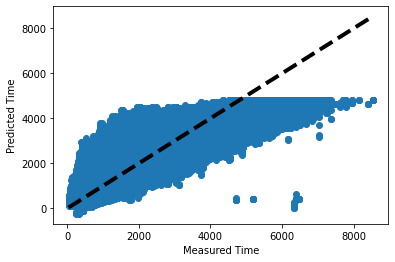

In [60]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Testing with some random points

In [61]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df):
    return my_model.predict(df[features])

In [62]:
def compare(actual, predicted):
#     actual = [act[0] for act in actual[outcome].values.tolist()]
#     predicted = predicted.tolist()
    return pd.DataFrame(data = {'actual': actual, 'prediction': predicted})

In [63]:
def get_random_points_in_bangalore(number):
    points = []
    min_x, min_y, max_x, max_y = 12.85, 77.45, 13.0, 77.75  
    i= 0
    while i < number:
        point = (random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        i += 1
        points.append(point)
    return points


In [64]:
points = [((12.999289603200602, 77.72750046509455),
  (12.900586869608652, 77.57751972070913)),
 ((12.935917259525278, 77.61353555551875),
  (12.856440148061886, 77.48546536718554)),
 ((12.897459477917653, 77.7095308106631),
  (12.996842230621631, 77.64938231715406)),
 ((12.936661694778596, 77.71873838420447),
  (12.907286088453898, 77.4772158363428)),
 ((12.88453533783865, 77.70914845848147),
  (12.893719016027402, 77.71748845762684)),
 ((12.90661849980788, 77.6359030720415),
  (12.986913454190185, 77.6667791482254)),
 ((12.89600641097292, 77.70444731327966),
  (12.98987526206819, 77.60524558740501)),
 ((12.897523292566822, 77.56067149766076),
  (12.894608188894253, 77.66337661025209)),
 ((12.86194623889842, 77.56338966329798),
  (12.944443289052925, 77.4887976744094)),
 ((12.858621405573748, 77.46556646993612),
  (12.90990445061544, 77.58937083560666))]

hours_of_day = [18, 7, 18, 2, 16, 23, 10, 8, 4, 16]

In [65]:
# taking average of thetime bounds given by manual google maps travel times for same coordinates and departure time
travel_times_gmaps_in_mins = [75, 55, 43, 63, 7, 45, 60, 50, 40, 50]
travel_times_gmaps = [t*60 for t in travel_times_gmaps_in_mins]

In [66]:
travel_times_model = []
points1 = [p[0] for p in points]
points2 = [p[1] for p in points]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod))
    p = p.tolist()[0]
    travel_times_model.append(p)
[t/60 for t in travel_times_model]

[70.92383626302083,
 49.459554036458336,
 54.1020751953125,
 42.60961100260417,
 9.989990234375,
 28.461260986328124,
 56.235677083333336,
 43.97960205078125,
 26.589447021484375,
 56.15357666015625]

In [67]:
compare(travel_times_gmaps, travel_times_model)

,actual,prediction
0,4500,4255.430176
1,3300,2967.573242
2,2580,3246.124512
3,3780,2556.576660
4,420,599.399414
5,2700,1707.675659
6,3600,3374.140625
7,3000,2638.776123
8,2400,1595.366821
9,3000,3369.214600


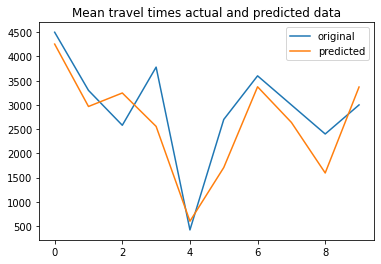

In [68]:
x_ax = range(len(travel_times_model))
plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

## Live Testing

In [69]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
hod = 10

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1725.0848], dtype=float32)